In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2DTranspose, Conv2D, Flatten, Embedding, Input, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
#LOADING DATASETS
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
#IMAGES ARE  60000 AND CONSISTS OF 10 CLASSES SO WE GIVE CLASSES NAME A S LABLES AND DESCRIPTION TO EACH IMAGE
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
descriptions = [f"A photo of a {labels[label[0]]}" for label in y_train]


In [ ]:
#RESIZING THE IMAGE
x_train = x_train / 255.0
x_test = x_test / 255.0


In [ ]:
def build_generator():
    noise_input = Input(shape=(100,))
    text_input = Input(shape=(1,), dtype='int32')

    text_embedding = Embedding(input_dim=len(labels), output_dim=50)(text_input)
    text_embedding = Flatten()(text_embedding)

    combined_input = concatenate([noise_input, text_embedding])

    x = Dense(256, activation='relu')(combined_input)
    x = BatchNormalization()(x)
    x = Reshape((16, 16, 1))(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(3, (4, 4), padding='same', activation='sigmoid')(x)

    return Model([noise_input, text_input], x)


In [ ]:
def build_discriminator():
    image_input = Input(shape=(32, 32, 3))
    text_input = Input(shape=(1,), dtype='int32')

    text_embedding = Embedding(input_dim=len(labels), output_dim=50)(text_input)
    text_embedding = Flatten()(text_embedding)
    text_embedding = Dense(32 * 32 * 3)(text_embedding)
    text_embedding = Reshape((32, 32, 3))(text_embedding)

    combined_input = concatenate([image_input, text_embedding])

    x = Conv2D(64, (3, 3), padding='same')(combined_input)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, text_input], x)



In [ ]:
# Build and compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build generator
generator = build_generator()

# Freeze discriminator during GAN training
discriminator.trainable = False

# Combine generator and discriminator to form GAN
gan_input = [Input(shape=(100,)), Input(shape=(1,))]
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam())



AssertionError: Exception encountered when calling layer "model" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")

Call arguments received by layer "model" (type Functional):
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
  • training=None
  • mask=None

In [ ]:
import numpy as np

def train_gan(gan, generator, discriminator, x_train, descriptions, epochs=100, batch_size=64):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, 100))  # Latent space
        generated_images = generator.predict(noise)

        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_labels)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

train_gan(gan, generator, discriminator, x_train, descriptions)


2/2 [==============================] - 0s 40ms/step
0 [D loss: 0.705988198518753 | D accuracy: 0.7421875] [G loss: 0.805607795715332]
2/2 [==============================] - 0s 40ms/step


In [ ]:
num_samples = 25  # Number of images to generate for evaluation
noise_for_evaluation = np.random.normal(0, 1, (num_samples, 100))  # Generate random noise
generated_images = generator.predict(noise_for_evaluation)


1/1 [==============================] - 0s 137ms/step


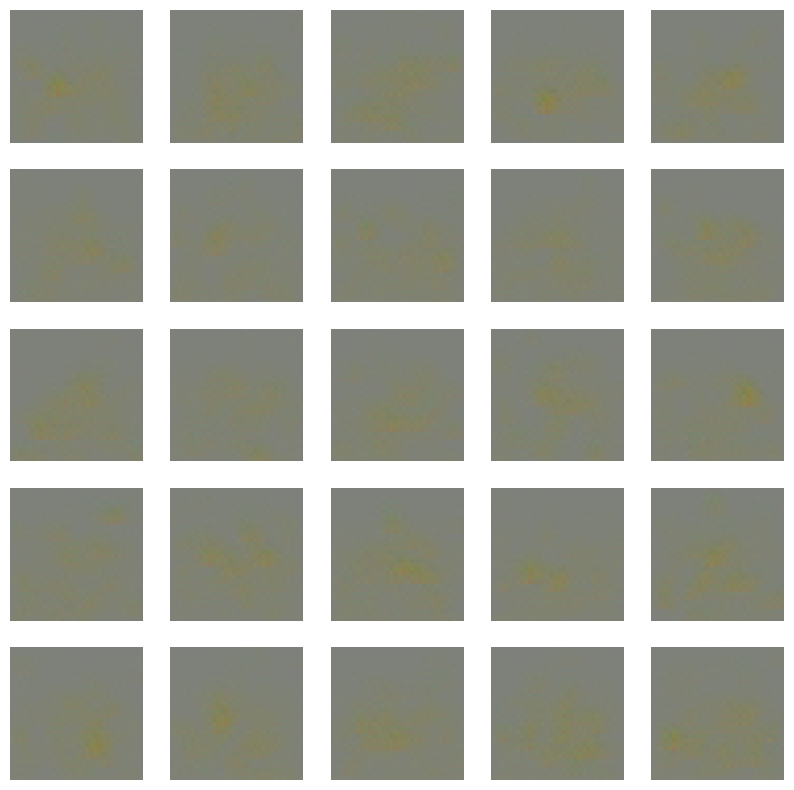

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i])
    ax.axis('off')
plt.show()


In [ ]:
# Example code for calculating Inception Score (assuming you have a pretrained Inception model)
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.stats import entropy

def calculate_inception_score(images, model=InceptionV3(), num_splits=10):
    scores = []
    for i in range(num_splits):
        preds = model.predict(images[i * (len(images) // num_splits):(i + 1) * (len(images) // num_splits)])
        preds = preds.squeeze()
        p_yx = np.exp(preds) / np.exp(preds).sum(axis=1, keepdims=True)
        p_y = p_yx.mean(axis=0, keepdims=True)
        scores.append(entropy(p_yx.T, p_y.T))
    return np.mean(scores), np.std(scores)

resized_images = np.array([resize(image, (299, 299, 3)) for image in generated_images])
inception_score, _ = calculate_inception_score(preprocess_input(resized_images))
print(f"Inception Score: {inception_score}")


1/1 [==============================] - 0s 449ms/step
Inception Score: 3.955179579406831e-07
